In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier as RandomForest

import matplotlib.cm as cmx
import matplotlib.colors as colors

from bs4 import BeautifulSoup
import urllib

### Reading in data:

In [2]:
shot_data = pd.read_csv('data/NBA_hothands_data.csv',delimiter=',')
shooters = pd.read_csv('data/shooter_bio_data.csv',delimiter=',')
defenders = pd.read_csv('data/defender_bio_data.csv',delimiter=',')
# shot_final = pd.read_csv('data/benny_data.csv',delimiter=',')
# shot_final = shot_final.drop('Unnamed: 0',axis=1)

flt = pd.read_csv('data/float.csv',delimiter=',')
Y = flt.FGM.copy()

player_diff = pd.read_csv('data/player_diff.csv',delimiter=',')
streak = pd.read_csv('data/streak.csv',delimiter=',')
xcat = pd.read_csv('data/X_categ.csv',delimiter=',')
xfloat = pd.read_csv('data/X_float.csv',delimiter=',')
players = pd.read_csv('data/player.csv',delimiter=',')

shot_final = pd.concat([xcat,xfloat,players,player_diff,streak],axis=1)
shot_final = shot_final.drop('bio',axis=1)
shot_final = shot_final.rename(columns={'0':'period_1',
                                        '1':'period_2',
                                        '2':'period_3',
                                        '3':'period_4',
                                        '4':'period_5',
                                        '5':'period_6',
                                        '6':'period_7'})

# Defining analysis functions for Logistic Regression:

In [3]:
def random_subsample(x,y,subsample_size):
    # obtain a random subsample of the data
    permuted_ind = np.random.permutation(x.shape[0]) # permute a set of indices
    subsample_ind = permuted_ind[0:int(round(subsample_size*x.shape[0]))] # take a fraction of these permuted indices
    x_subsample = x.iloc[subsample_ind,:] # select the data using subsample of indices
    y_subsample = y.iloc[subsample_ind]
    t = int(round(subsample_size*x.shape[0]))
    x_OOB = x.iloc[t:,:]
    y_OOB = y.iloc[t:]
    return x_subsample,y_subsample,x_OOB,y_OOB

In [4]:
def LogReg_analysis(X_data,Y_data,subsample_size,C_values,repeats):
    intercepts = np.zeros([repeats,len(C_values)])
    coeffs = np.zeros([repeats,len(C_values),len(X_data.columns)])
    acc = np.zeros([repeats,len(C_values)])
    for i in range(repeats):
        x_data,y_data,OOB_x,OOB_y = random_subsample(X_data,Y_data,subsample_size)
        for k in range(len(C_values)):
            LR_mod = LogReg(C=C_values[k])
            LR_mod.fit(x_data,y_data)
            acc[i,k] = LR_mod.score(OOB_x,OOB_y)
            coeffs[i,k,:] = LR_mod.coef_
            intercepts[i,k] = LR_mod.intercept_
    comb_coeffs = np.zeros([repeats,len(C_values),len(X_data.columns)+1])   
    comb_coeffs[:,:,:-1] = coeffs
    comb_coeffs[:,:,-1] = intercepts
    
    acc_data = acc
    coeff_data = comb_coeffs
    coeff_names = list(X_data.columns) + ['intercept']
    reg_param_values = C_values
    
    fig = plt.figure(figsize = (8,15))
    ax1 = fig.add_subplot(311)
    ax1.errorbar(reg_param_values,acc_data.mean(axis=0),yerr=acc_data.std(axis=0),fmt='o-')
    ax1.grid(True)
    ax1.set_ylabel('Prediction Accuracy')
    ax1.set_xlabel('Model Parameter')
    ax1.set_title('Effect of Model Parameter on Prediction Accuracy')
    
    ax3 = fig.add_subplot(312)
    ax3.plot(reg_param_values,acc_data.std(axis=0),'o-')
    ax3.grid(True)
    ax3.set_ylabel('Model STD across subsamples')
    ax3.set_xlabel('MOdel Parameter')
    ax3.set_title('Effect of Model Parameter on Model Generality')
    
    ax2 = fig.add_subplot(313)
    ax2.errorbar(range(coeff_data.shape[2]), coeff_data[:,-1,:].mean(axis=0),
                 yerr=coeff_data[:,-1,:].std(axis=0),
                fmt='o-')
    ax2.grid(True)
    ax2.set_ylabel('Coefficient value')
    ax2.set_title('Average variable importance')
    ax2.set_xticks(range(len(coeff_names)))
    ax2.set_xticklabels(coeff_names,rotation=80,fontsize=15)
    
    return acc,comb_coeffs

In [5]:
def LogReg_analysis_nograph(X_data,Y_data,subsample_size,C_values,repeats):
    intercepts = np.zeros([repeats,len(C_values)])
    coeffs = np.zeros([repeats,len(C_values),len(X_data.columns)])
    acc = np.zeros([repeats,len(C_values)])
    for i in range(repeats):
        x_data,y_data,OOB_x,OOB_y = random_subsample(X_data,Y_data,subsample_size)
        for k in range(len(C_values)):
            LR_mod = LogReg(C=C_values[k])
            LR_mod.fit(x_data,y_data)
            acc[i,k] = LR_mod.score(OOB_x,OOB_y)
            coeffs[i,k,:] = LR_mod.coef_
            intercepts[i,k] = LR_mod.intercept_
    comb_coeffs = np.zeros([repeats,len(C_values),len(X_data.columns)+1])   
    comb_coeffs[:,:,:-1] = coeffs
    comb_coeffs[:,:,-1] = intercepts
    
    return acc,comb_coeffs

### gathering list of shooter and defender names

In [6]:
shooter_names = shot_final.player_name.unique()
defender_names = shot_final.CLOSEST_DEFENDER.unique()
print shooters.columns.get_values()

['full_name' 'bio_url' 'height' 'weight' 'birth_year' 'height_in'
 'weight_lbs' 'age_years']


### Adding columns with shooter height, weight, and number of shots taken:

In [7]:
shot_final['num_shots_taken'] = 'x'
shot_final['shooter_height'] = np.nan
shot_final['shooter_weight'] = np.nan
for i in range(len(shooter_names)):
    sh_data = shooters[shooters.full_name==shooter_names[i]] # grabbing shooter data
    
    # shooter heights
    if sh_data.height_in.item()=='x':
        shot_final.loc[shot_final.player_name==shooter_names[i],'shooter_height']=np.nan
    else:
        shot_final.loc[shot_final.player_name==shooter_names[i],'shooter_height'] = int(sh_data.height_in)
    
    # shooter weights
    if sh_data.weight_lbs.item()=='x':
        shot_final.loc[shot_final.player_name==shooter_names[i],'shooter_weight']=np.nan
    else:
        shot_final.loc[shot_final.player_name==shooter_names[i],'shooter_weight'] = int(sh_data.weight_lbs)
    
    # number of shots taken by shooter
    shot_final.loc[shot_final.player_name==shooter_names[i],'num_shots_taken'] = shot_final[shot_final.player_name==shooter_names[i]].shape[0]
    
    # printing progress of loop
    if i%50==0:
        print "completed %d out of %d..." % (i,shooter_names.shape[0])
    

completed 0 out of 281...
completed 50 out of 281...
completed 100 out of 281...
completed 150 out of 281...
completed 200 out of 281...
completed 250 out of 281...


In [8]:
defenders.columns

Index([u'full_name', u'bio_url', u'height', u'weight', u'birth_year',
       u'height_in', u'weight_lbs', u'age_years'],
      dtype='object')

### Adding columns with defender height and weight:

In [9]:
shot_final['defender_height'] = np.nan
shot_final['defender_weight'] = np.nan
for i in range(len(defender_names)):
    sh_data = defenders[defenders.full_name==defender_names[i]] # grabbing shooter data
    
    # shooter heights
    if sh_data.height_in.item()=='x':
        shot_final.loc[shot_final.CLOSEST_DEFENDER==defender_names[i],'defender_height'] = np.nan
    else:
        shot_final.loc[shot_final.CLOSEST_DEFENDER==defender_names[i],'defender_height'] = int(sh_data.height_in)
    
    # shooter weights
    if sh_data.weight_lbs.item()=='x':
        shot_final.loc[shot_final.CLOSEST_DEFENDER==defender_names[i],'defender_weight'] = np.nan
    else:
        shot_final.loc[shot_final.CLOSEST_DEFENDER==defender_names[i],'defender_weight'] = int(sh_data.weight_lbs)
    
    
    # printing progress of loop
    if i%50==0:
        print "completed %d out of %d..." % (i,defender_names.shape[0])

completed 0 out of 473...
completed 50 out of 473...
completed 100 out of 473...
completed 150 out of 473...
completed 200 out of 473...
completed 250 out of 473...
completed 300 out of 473...
completed 350 out of 473...
completed 400 out of 473...
completed 450 out of 473...


### Explicitly showing which shooters and defenders have missing data:

In [10]:
# missing shooter data is for misspelled names:
missing_shooter_data = []
for i in range(len(shooter_names)):
    if shooters[shooters.full_name==shooter_names[i]].height_in.item()=='x':
        missing_shooter_data.append(shooter_names[i])
for k in range(len(missing_shooter_data)):
    print missing_shooter_data[k]

jimmer dredette
mnta ellis
dirk nowtizski
beno urdih


In [11]:
# missing defender data mostly for abnormal types of names (abbreviations, Initials, "Jr", etc...)
missing_defender_data = []
for i in range(len(defender_names)):
    if defenders[defenders.full_name==defender_names[i]].height_in.item()=='x':
        missing_defender_data.append(defender_names[i])
for k in range(len(missing_defender_data)):
    print missing_defender_data[k]

Augustin, D.J.
Mbah a Moute, Luc
Mayo, O.J.
Smith, J.R.
Price, A.J.
O'Quinn, Kyle
O'Bryant, Johnny
Ayres, Jeff
Kidd-Gilchrist, Michael
Hairston, PJ
Moore, E'Twaun
Walker, Henry
Datome, Gigi
Capela, Clint
Rice Jr., Glen
Dos Santos, Atila


### Filling missing values (nan) with column mean:

In [12]:
# fill missing values with mean of column
shot_final['shooter_height'] = shot_final['shooter_height'].fillna(shot_final.shooter_height.mean())
shot_final['shooter_weight'] = shot_final['shooter_weight'].fillna(shot_final.shooter_weight.mean())
shot_final['defender_height'] = shot_final['defender_height'].fillna(shot_final.defender_height.mean())
shot_final['defender_weight'] = shot_final['defender_weight'].fillna(shot_final.defender_weight.mean())

---

# Visualizing: Shots taken, Shot Distances, Player Heights

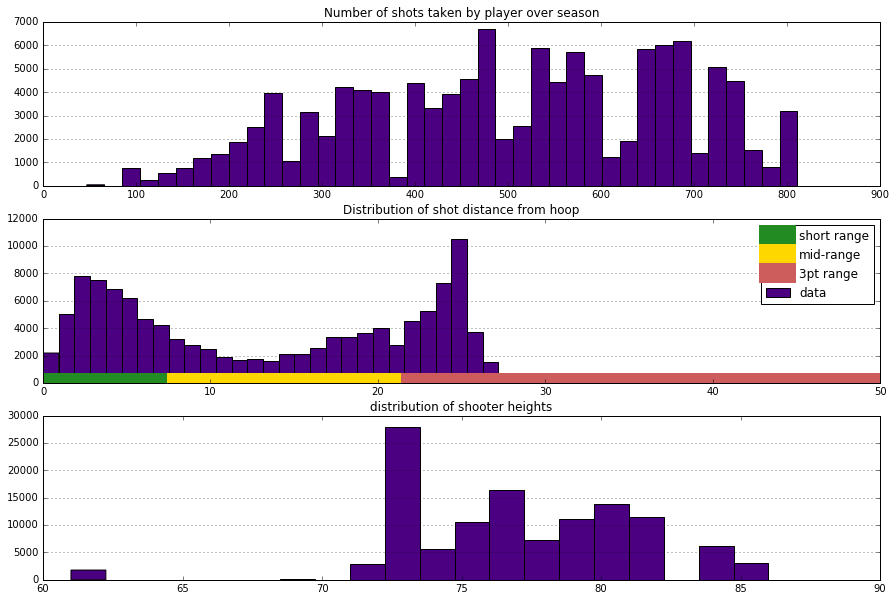

In [13]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.hist(shot_final.num_shots_taken,40,color='indigo')
ax1.set_title('Number of shots taken by player over season')
ax1.yaxis.grid(True)

ax2.hist(shot_final.SHOT_DIST,50,label='data',color='indigo')
ax2.set_title('Distribution of shot distance from hoop')
ax2.plot(np.array([0,8]),np.array([0,0]),linewidth=20,color = 'forestgreen',label='short range')
ax2.plot(np.array([8,22]),np.array([0,0]),linewidth=20,color = 'gold',label='mid-range')
ax2.plot(np.array([22,50]),np.array([0,0]),linewidth=20,color = 'indianred',label='3pt range')
ax2.legend()
ax2.yaxis.grid(True)

ax3.hist(shot_final.shooter_height,20,color='indigo')
ax3.set_title('distribution of shooter heights')
ax3.yaxis.grid(True)

plt.show()

# Taller players tend to take shots closer to the hoop

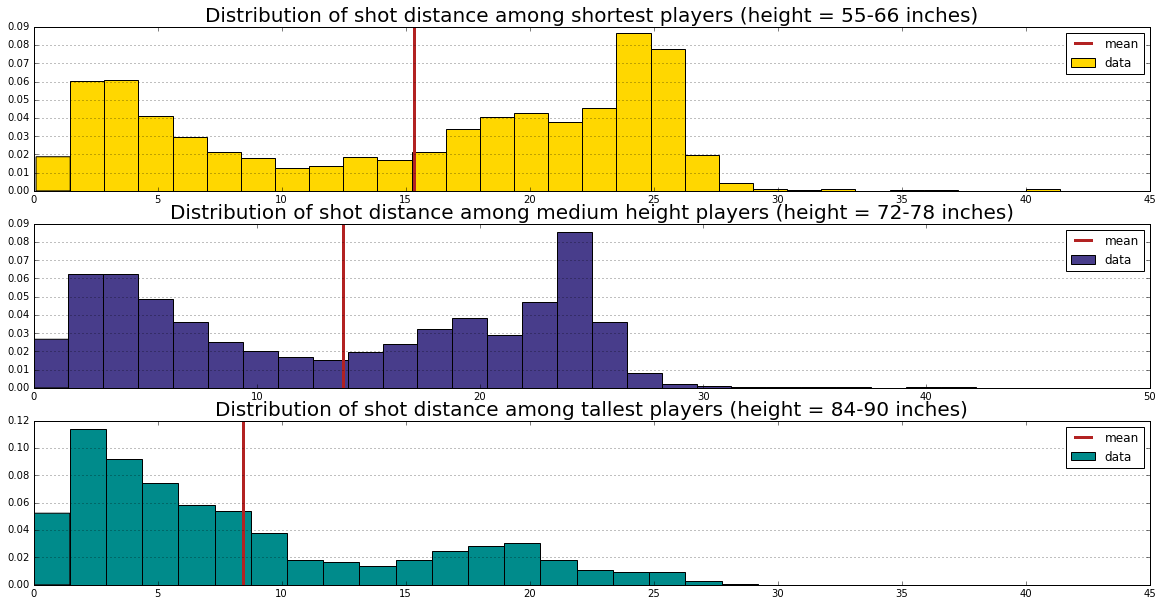

In [14]:
height_bins = np.array([55,66,72,78,84,90])
data_list = []
for i in range(len(height_bins)-1):
    dd = shot_final[(shot_final.shooter_height>=height_bins[i]) & (shot_final.shooter_height<height_bins[i+1])]
    data_list.append(dd.SHOT_DIST)
    
    
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.hist(data_list[0],30,color='gold',label='data',normed=True)
ax1.set_title('Distribution of shot distance among shortest players (height = 55-66 inches)',fontsize=20)
ax1.axvline(data_list[0].mean(),color = 'firebrick',linewidth=3,label = 'mean')
ax1.legend()
ax1.yaxis.grid(True)

ax2.hist(data_list[2],30,color='darkslateblue',label='data',normed=True)
ax2.set_title('Distribution of shot distance among medium height players (height = 72-78 inches)',fontsize=20)
ax2.axvline(data_list[2].mean(),color = 'firebrick',linewidth=3,label = 'mean')
ax2.legend()
ax2.yaxis.grid(True)

ax3.hist(data_list[4],30,color='darkcyan',label='data',normed=True)
ax3.set_title('Distribution of shot distance among tallest players (height = 84-90 inches)',fontsize=20)
ax3.axvline(data_list[4].mean(),color = 'firebrick',linewidth=3,label = 'mean')
ax3.legend()
ax3.yaxis.grid(True)

plt.show()

# Shots close to the hoop tend to have closer defenders

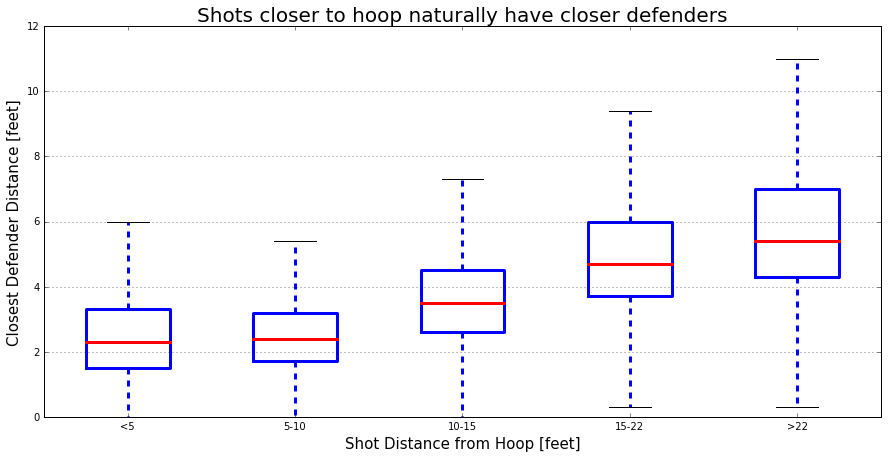

In [15]:
shot_dist_bins = np.array([0,5,10,15,22,50])
data_list = []
bin_name_list = ['<5','5-10','10-15','15-22','>22']
for i in range(len(shot_dist_bins)-1):
    dd = shot_final[(shot_final.SHOT_DIST>=shot_dist_bins[i]) & (shot_final.SHOT_DIST<shot_dist_bins[i+1])]
    data_list.append(dd.CLOSE_DEF_DIST)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

boxp = dict(linewidth=3)
medp = dict(linewidth=3)
flierp = dict(linewidth=3)
wp = dict(linewidth=3)
ax.boxplot(data_list,showfliers=False,boxprops=boxp,flierprops = flierp,medianprops=medp,whiskerprops=wp)
ax.set_xticklabels(bin_name_list)
ax.set_title('Shots closer to hoop naturally have closer defenders',fontsize = 20)
ax.set_xlabel('Shot Distance from Hoop [feet]',fontsize=15)
ax.set_ylabel('Closest Defender Distance [feet]',fontsize = 15)
ax.yaxis.grid(True)
plt.show()

# Relationship between closest defender distance and shot success: 
### Shot Distance Dependence

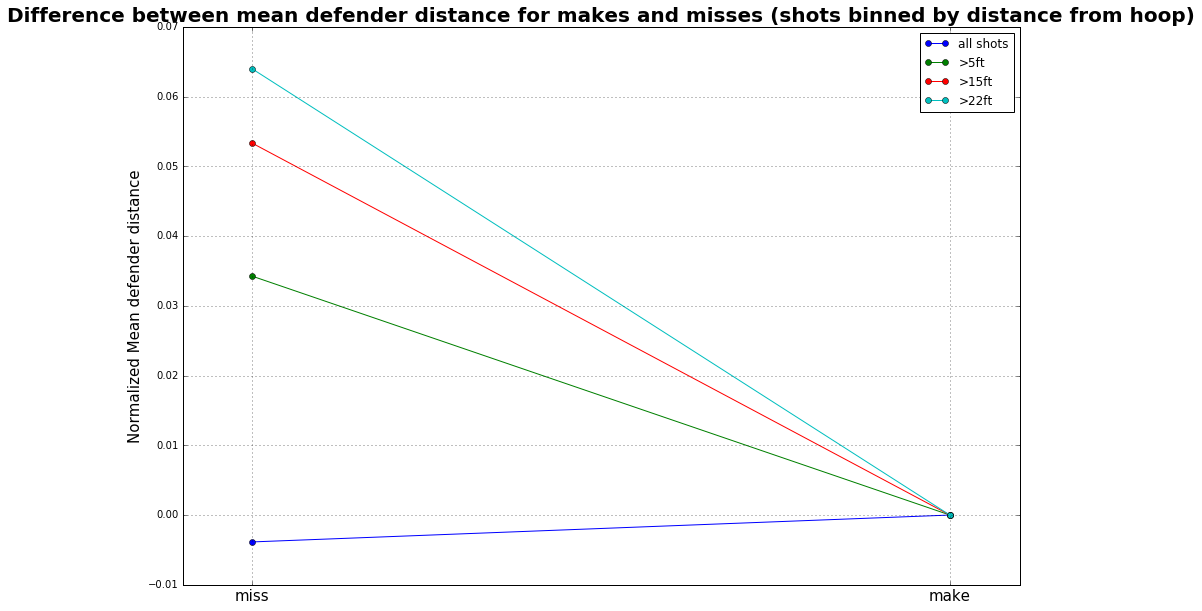

In [16]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
distances = np.array([0,5,15,22])
label_list = ['all shots','>5ft','>15ft','>22ft']
xtick_label_list = ['miss','make']
for i in range(len(distances)):
    dd2 = shot_final[(shot_final.SHOT_DIST>distances[i])]
    dd2y = Y[(shot_final.SHOT_DIST>distances[i])]
    dd2_list = [dd2[dd2y==1].CLOSE_DEF_DIST,dd2[dd2y==0].CLOSE_DEF_DIST]
    mean_miss_dist = dd2_list[1].mean()
    mean_make_dist = dd2_list[0].mean()
    ax.plot(np.array([1,0]),np.array([0,(mean_make_dist-mean_miss_dist)/mean_miss_dist]),'o-',label = label_list[i])
    ax.set_xlim([-0.1,1.1])
ax.legend()
ax.set_xticks([0,1])
ax.set_xticklabels(xtick_label_list,fontsize=15)
ax.grid(True)
ax.set_ylabel('Normalized Mean defender distance',fontsize = 15)
ax.set_title('Difference between mean defender distance for makes and misses (shots binned by distance from hoop)',fontsize=20,weight='bold')
plt.show()


*** adding interaction term for height and weight***

In [17]:
shot_final['height_weight_int'] = np.multiply(np.array(shot_final.defender_height),np.array(shot_final.defender_weight))

*** adding interaction term for shot_dist/close_def_dist***

In [18]:
shot_final['shot_dist/def_dist'] = np.divide(np.array(shot_final.SHOT_DIST),np.array(shot_final.CLOSE_DEF_DIST))
shot_final['shot_dist/def_dist'] = shot_final['shot_dist/def_dist'].replace(np.inf,np.nan)
shot_final['shot_dist/def_dist'] = shot_final['shot_dist/def_dist'].fillna(1000)


### Normalizing numerical predictors:

In [21]:
cols = shot_final.columns
minmax = MinMaxScaler()
shot_final_norm = shot_final.copy()
for i in range(len(cols)):
    dd = shot_final[cols[i]]
    if (type(shot_final[cols[i]][2])!=str) & (len(shot_final[cols[i]].unique())>2):
        shot_final_norm[cols[i]] = minmax.fit_transform(shot_final[cols[i]].reshape(-1,1)).copy()
        print cols[i]

FINAL_MARGIN
SHOT_NUMBER
SHOT_CLOCK
DRIBBLES
TOUCH_TIME
SHOT_DIST
CLOSE_DEF_DIST
time_zero
game_clock_float
h_diff
w_diff
a_diff
con_shot
con_miss
shot_percent_4
num_shots_taken
shooter_height
shooter_weight
defender_height
defender_weight
height_weight_int
shot_dist/def_dist


/Users/rishisingh/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/rishisingh/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/rishisingh/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/rishisingh/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/rishisingh/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversi

In [22]:
shot_final_norm.head()

,period_1,period_2,period_3,period_4,period_5,period_6,period_7,FINAL_MARGIN,SHOT_NUMBER,SHOT_CLOCK,...,con_miss,shot_percent_4,previous_shot_4,num_shots_taken,shooter_height,shooter_weight,defender_height,defender_weight,height_weight_int,shot_dist/def_dist
0,1,0,0,0,0,0,0,0.726415,0.000000,0.450000,...,0.000000,0.000000,0,0.40445,0.48,0.09375,0.68,0.404110,0.509524,0.005923
1,1,0,0,0,0,0,0,0.726415,0.052632,0.141667,...,0.000000,1.000000,1,0.40445,0.48,0.09375,0.68,0.301370,0.419295,0.004623
2,1,0,0,0,0,0,0,0.726415,0.105263,0.000000,...,0.076923,0.500000,1,0.40445,0.48,0.09375,0.68,0.301370,0.419295,0.011222
3,0,1,0,0,0,0,0,0.726415,0.157895,0.429167,...,0.153846,0.333333,1,0.40445,0.48,0.09375,0.56,0.164384,0.256189,0.005059
4,0,1,0,0,0,0,0,0.726415,0.210526,0.454167,...,0.230769,0.250000,1,0.40445,0.48,0.09375,0.76,0.410959,0.549626,0.003364


In [23]:
shot_final.head()

,period_1,period_2,period_3,period_4,period_5,period_6,period_7,FINAL_MARGIN,SHOT_NUMBER,SHOT_CLOCK,...,con_miss,shot_percent_4,previous_shot_4,num_shots_taken,shooter_height,shooter_weight,defender_height,defender_weight,height_weight_int,shot_dist/def_dist
0,1,0,0,0,0,0,0,24,1,10.8,...,0,0.000000,0,356,73,173,78,220,17160,5.923077
1,1,0,0,0,0,0,0,24,2,3.4,...,0,1.000000,1,356,73,173,78,205,15990,4.622951
2,1,0,0,0,0,0,0,24,3,0.0,...,1,0.500000,1,356,73,173,78,205,15990,11.222222
3,0,1,0,0,0,0,0,24,4,10.3,...,2,0.333333,1,356,73,173,75,185,13875,5.058824
4,0,1,0,0,0,0,0,24,5,10.9,...,3,0.250000,1,356,73,173,80,221,17680,3.363636


---

# Shot distance affects variable importance

In [71]:
# List of predictors to use in regression
pred_list = ['period_2',
            'CLOSE_DEF_DIST',
            'SHOT_CLOCK',
            'DRIBBLES',
            'TOUCH_TIME',
            'SHOT_DIST',
            'h_diff',
             'w_diff',
            'shot_percent_4']

dist = [0,5,10,15,20,25,50] # distances to use for binning
dist_labels = ['<5ft','5-10ft','10-15ft','15-20ft','20-25ft','>25ft'] # labels for bins

# initialize
acc_list = []
coeff_list = []
dummy_prediction = []

# loop through all bins:
for i in range(len(dist)-1):
    
    # grab x and y data
    ddX = shot_final_norm.loc[((shot_final.SHOT_DIST>=dist[i]) & (shot_final.SHOT_DIST<dist[i+1]))][pred_list]
    ddY = Y.loc[((shot_final.SHOT_DIST>=dist[i]) & (shot_final.SHOT_DIST<dist[i+1]))]
    
    # calculate dummy prediction (all shots go in or all shots miss)
    shot_percent = ddY.sum(axis=0)*1.0/ddY.shape[0]
    dummy_prediction.append(max([shot_percent,(1.0-shot_percent)]))
    
    # do the analysis using the custom functions, save coefficients and accuracies from each bin
    [a,c] = LogReg_analysis_nograph(ddX,ddY,0.2,[1],100)
    acc_list.append(a)
    coeff_list.append(c)
    
    print "testing distance range %d out of %d..." % (i+1,(len(dist)-1))

testing distance range 1 out of 6...
testing distance range 2 out of 6...
testing distance range 3 out of 6...
testing distance range 4 out of 6...
testing distance range 5 out of 6...
testing distance range 6 out of 6...


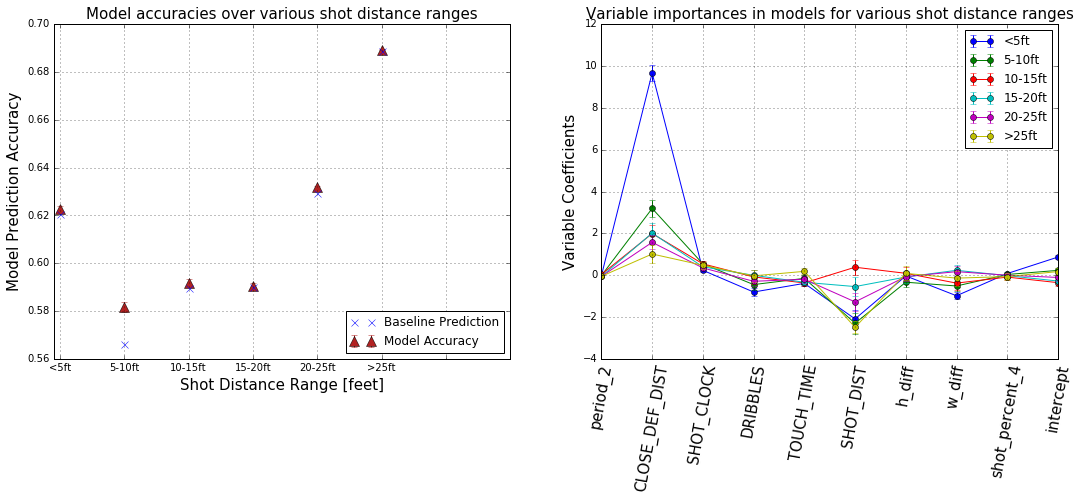

In [74]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# loop through each bin to graph
for i in range(len(dist)-1):
    
    # if this is the first plot, write the labels, otherwise the labels are already written and don't repeat
    if i==0:
        ax1.errorbar(i,acc_list[i].mean(axis=0),yerr=acc_list[i].std(axis=0),fmt='^',markersize=10,color='firebrick',
                    label='Model Accuracy')
        ax1.plot(i,dummy_prediction[i],'x',markersize=7,color = 'blue',label='Baseline Prediction')

    else:
        ax1.errorbar(i,acc_list[i].mean(axis=0),yerr=acc_list[i].std(axis=0),fmt='^',markersize=10,color='firebrick')
        ax1.plot(i,dummy_prediction[i],'x',markersize=7,color = 'blue')

    ax2.errorbar(range(coeff_list[i].shape[2]), coeff_list[i][:,-1,:].mean(axis=0),
             yerr=coeff_list[i][:,-1,:].std(axis=0),
             fmt='o-',
             label = dist_labels[i])
    
    ax2.set_ylabel('Coefficient value')
    ax2.set_title('Average variable importance')
    ax2.set_xticks(range(len(pred_list)+1))
    PL_2 = pred_list + ['intercept']
    ax2.set_xticklabels(PL_2,rotation=80,fontsize=15)

ax1.set_title('Model accuracies over various shot distance ranges',fontsize=15)
ax1.grid(True)
ax1.set_xlim([-0.1,1.5])
ax1.set_xticks(range(len(dist_labels)+2))
ax1.set_xticklabels(dist_labels)
ax1.set_ylabel('Model Prediction Accuracy',fontsize = 15)
ax1.legend(loc=4)
ax1.set_xlabel('Shot Distance Range [feet]',fontsize = 15)

ax2.set_title('Variable importances in models for various shot distance ranges',fontsize = 15 )
ax2.legend()
ax2.set_ylabel('Variable Coefficients',fontsize = 15)
ax2.grid(True)


plt.show()

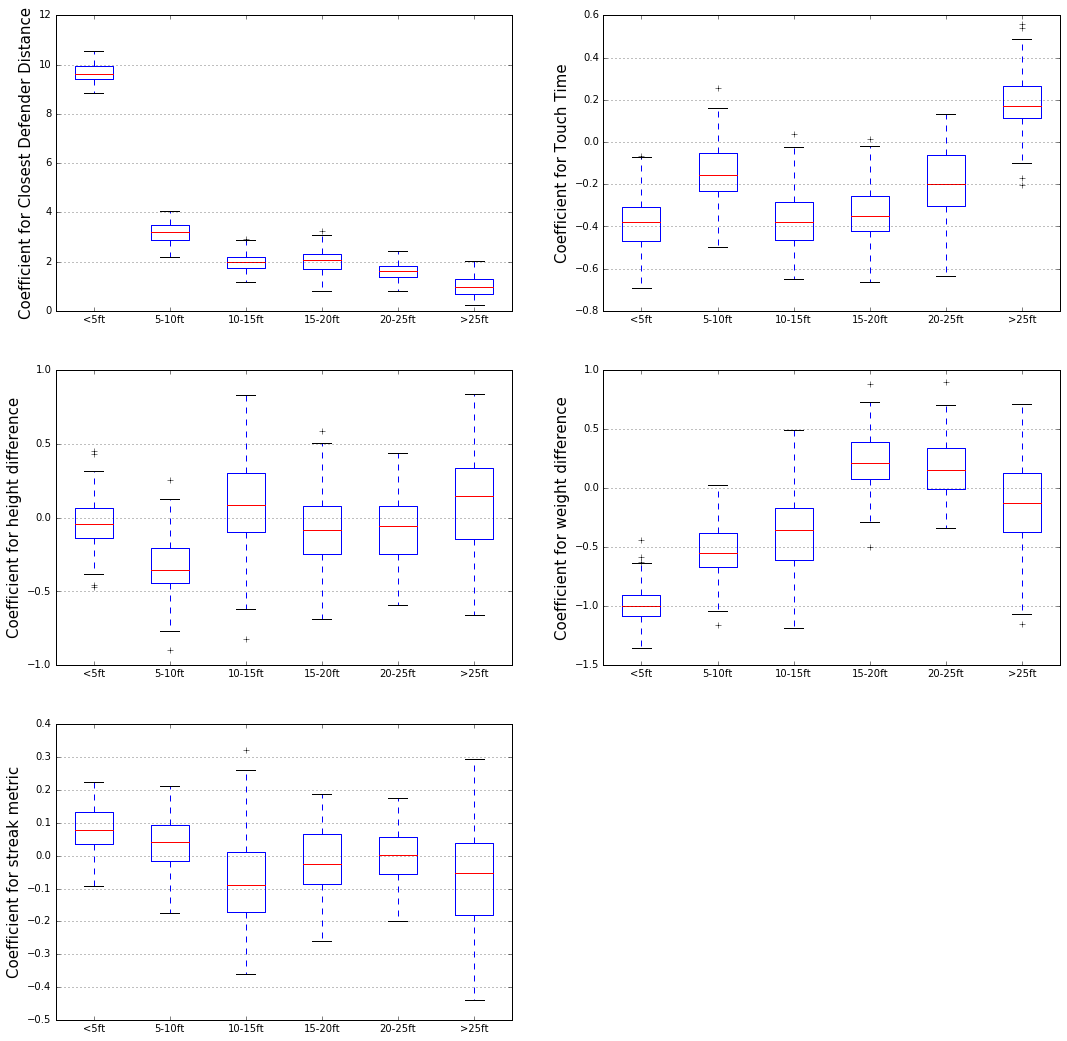

In [75]:
# comparing variable importances across different bins

# initialize subplots
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# initialize lists with coefficient data for all bootstrapped samples for various predictors
CDD_list = []
TT_list = []
streak_list = []
HD_list = []
WD_list = []

# loop through each shot distance bin:
for i in range(len(coeff_list)):
    CDD_list.append(coeff_list[i][:,0,1]) # close_def_dist coefficients
    TT_list.append(coeff_list[i][:,0,4])
    WD_list.append(coeff_list[i][:,0,7])
    HD_list.append(coeff_list[i][:,0,6])
    streak_list.append(coeff_list[i][:,0,8])

# make and label the plots
ax1.boxplot(CDD_list)
ax1.set_xticklabels(dist_labels)
ax1.set_ylabel('Coefficient for Closest Defender Distance',fontsize = 15)
ax1.yaxis.grid(True)

ax2.boxplot(TT_list)
ax2.set_xticklabels(dist_labels)
ax2.set_ylabel('Coefficient for Touch Time',fontsize = 15)
ax2.yaxis.grid(True)

ax3.boxplot(HD_list)
ax3.set_xticklabels(dist_labels)
ax3.set_ylabel('Coefficient for height difference',fontsize = 15)
ax3.yaxis.grid(True)

ax4.boxplot(WD_list)
ax4.set_xticklabels(dist_labels)
ax4.set_ylabel('Coefficient for weight difference',fontsize = 15)
ax4.yaxis.grid(True)

ax5.boxplot(streak_list)
ax5.set_xticklabels(dist_labels)
ax5.set_ylabel('Coefficient for streak metric',fontsize = 15)
ax5.yaxis.grid(True)


plt.show()

# Using shots greater than a certain distance from the hoop:

_This time, instead of ranges such as:_
'0-5ft', 
'5-10ft', 
etc...

_I have used ranges:_
'>5ft', 
'>10ft', 
etc...

In [76]:
pred_list = ['period_2',
            'CLOSE_DEF_DIST',
            'SHOT_CLOCK',
            'DRIBBLES',
            'TOUCH_TIME',
            'SHOT_DIST',
            'h_diff',
             'w_diff',
            'shot_percent_4']
dist = [5,10,15,20,25]
dist_labels = ['>5ft','>10ft','>15ft','>20ft','>25ft']
acc_list = []
coeff_list = []
dummy_prediction = []

for i in range(len(dist)):
    ddX = shot_final_norm.loc[((shot_final.SHOT_DIST>=dist[i]))][pred_list]
    ddY = Y.loc[((shot_final.SHOT_DIST>=dist[i]))]
    shot_percent = ddY.sum(axis=0)*1.0/ddY.shape[0]
    dummy_prediction.append(max([shot_percent,(1.0-shot_percent)]))

    [a,c] = LogReg_analysis_nograph(ddX,ddY,0.2,[1],100)
    acc_list.append(a)
    coeff_list.append(c)
    
    print "testing distance range %d out of %d..." % (i+1,(len(dist)))

testing distance range 1 out of 5...
testing distance range 2 out of 5...
testing distance range 3 out of 5...
testing distance range 4 out of 5...
testing distance range 5 out of 5...


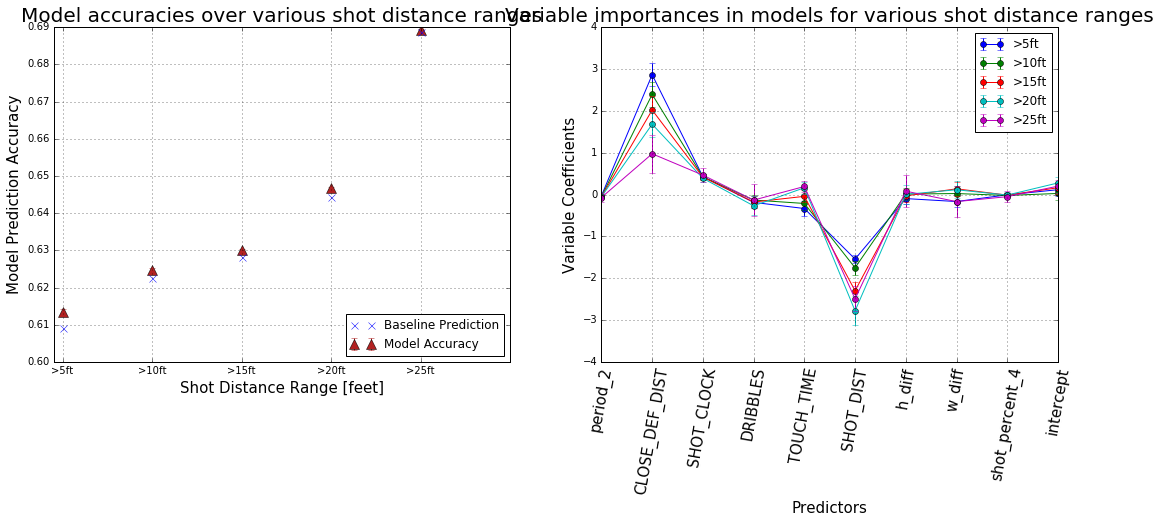

In [77]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(len(dist)):
    if i==0:
        ax1.errorbar(i,acc_list[i].mean(axis=0),yerr=acc_list[i].std(axis=0),fmt='^',markersize=10,color='firebrick',
                    label='Model Accuracy')
        ax1.plot(i,dummy_prediction[i],'x',markersize=7,color = 'blue',label='Baseline Prediction')

    else:
        ax1.errorbar(i,acc_list[i].mean(axis=0),yerr=acc_list[i].std(axis=0),fmt='^',markersize=10,color='firebrick')
        ax1.plot(i,dummy_prediction[i],'x',markersize=7,color = 'blue')

    ax2.errorbar(range(coeff_list[i].shape[2]), coeff_list[i][:,-1,:].mean(axis=0),
             yerr=coeff_list[i][:,-1,:].std(axis=0),
             fmt='o-',
             label = dist_labels[i])
    ax2.set_ylabel('Coefficient value')
    ax2.set_title('Average variable importance')
    ax2.set_xticks(range(len(pred_list)+1))
    PL_2 = pred_list + ['intercept']
    ax2.set_xticklabels(PL_2,rotation=80,fontsize=15)

ax1.set_title('Model accuracies over various shot distance ranges',fontsize=20)
ax1.grid(True)
ax1.set_xlim([-0.1,1.2])
ax1.set_xticks(range(len(dist_labels)+1))
ax1.set_xticklabels(dist_labels)
ax1.set_ylabel('Model Prediction Accuracy',fontsize = 15)
ax1.legend(loc=4)
ax1.set_xlabel('Shot Distance Range [feet]',fontsize = 15)

ax2.set_title('Variable importances in models for various shot distance ranges',fontsize =20 )
ax2.legend()
ax2.set_ylabel('Variable Coefficients',fontsize = 15)
ax2.set_xlabel('Predictors',fontsize = 15)
ax2.grid(True)


plt.show()

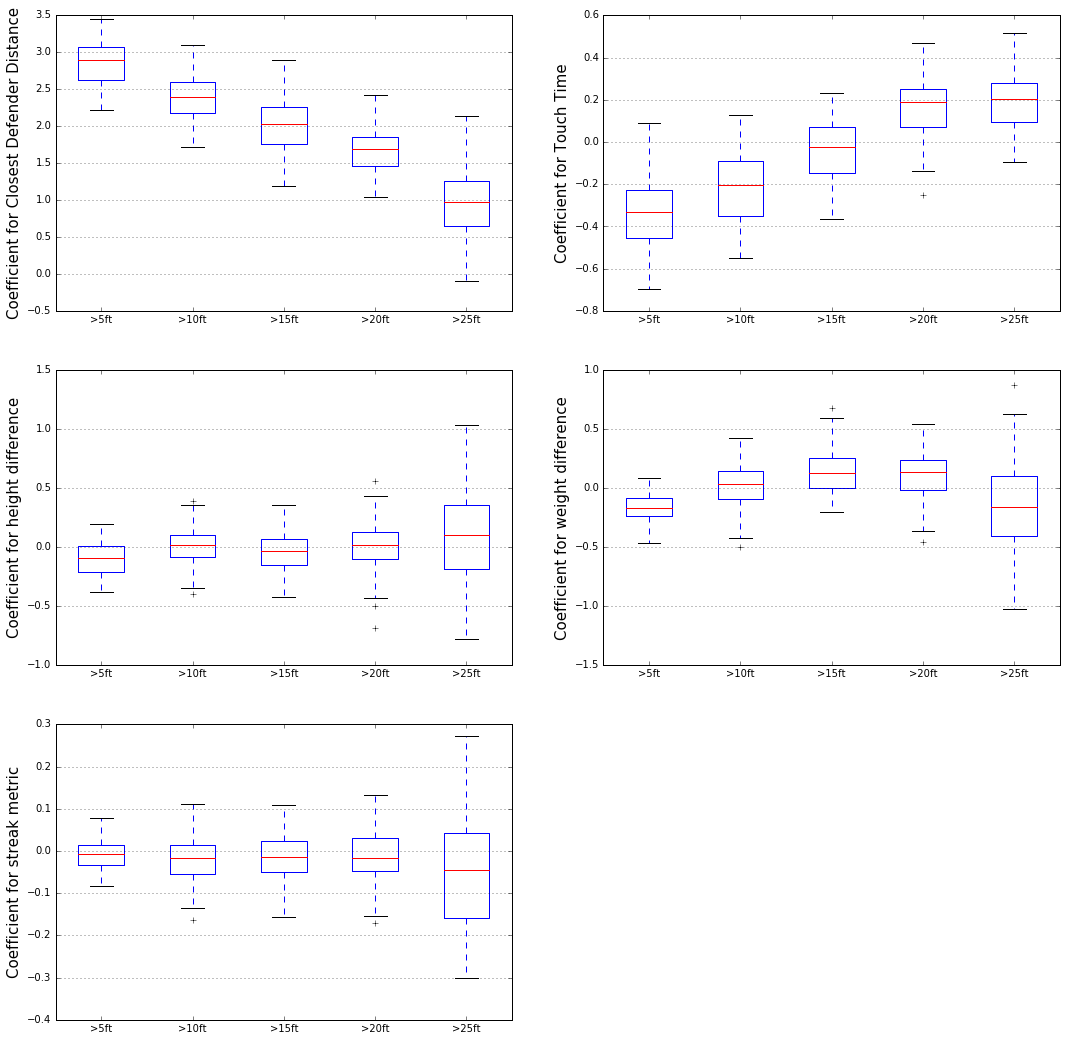

In [78]:
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
CDD_list = []
TT_list = []
streak_list = []
HD_list = []
WD_list = []
for i in range(len(coeff_list)):
    CDD_list.append(coeff_list[i][:,0,1]) # close_def_dist coefficients
    TT_list.append(coeff_list[i][:,0,4])
    WD_list.append(coeff_list[i][:,0,7])
    HD_list.append(coeff_list[i][:,0,6])
    streak_list.append(coeff_list[i][:,0,8])
    
ax1.boxplot(CDD_list)
ax1.set_xticklabels(dist_labels)
ax1.set_ylabel('Coefficient for Closest Defender Distance',fontsize = 15)
ax1.yaxis.grid(True)

ax2.boxplot(TT_list)
ax2.set_xticklabels(dist_labels)
ax2.set_ylabel('Coefficient for Touch Time',fontsize = 15)
ax2.yaxis.grid(True)

ax3.boxplot(HD_list)
ax3.set_xticklabels(dist_labels)
ax3.set_ylabel('Coefficient for height difference',fontsize = 15)
ax3.yaxis.grid(True)

ax4.boxplot(WD_list)
ax4.set_xticklabels(dist_labels)
ax4.set_ylabel('Coefficient for weight difference',fontsize = 15)
ax4.yaxis.grid(True)

ax5.boxplot(streak_list)
ax5.set_xticklabels(dist_labels)
ax5.set_ylabel('Coefficient for streak metric',fontsize = 15)
ax5.yaxis.grid(True)


plt.show()

# Patterns in the Data:

***Closest Defender Distance:*** The distance from a shooter to the nearest defender is an important predictor in whether or not the shooter is successful. Interestingly, this distance is most important when the shooter is closest to the hoop. As the shooter gets further away from the hoop, this distance becomes less important. 

This is interesting, since it is not an obvious relationship. While one would expect the defender distance to be predictive of whether or not someone makes a shot, the fact that it is more important close to the hoop is not as obvious.

This may, however, be an artifact of our dataset. The dataset only shows the closest defender's distance, not necessarily the person who is actively contesting the shooter's shot. Perhaps there is better correlation between the closest-defender-distance and the shot probability close to the hoop because the closest defender listed is likely to be the actual defender when the shooter is near the hoop.

***Touch Time:*** From the above analysis, we see that touch time (the time the ball is held by the shooter before shooting) is negatively correlated when the shot is close to the hoop, but becomes positively correlated for shots in the 3-point range. 

***Height Difference:*** Height difference doesn't seem to have much of an effect on the shot probability. However, it seems that it may have a significant effect for shots in the range of 5-10 feet. Perhaps mismatch defense is most effective for stopping midrange shots.

***Weight Difference:*** In both analyses looking at the shot-range dependence, weight the importance of weight difference peaks for jump shots in the 15-20ft range. When the defender weighs more than the shooter, it seems the shooter has an advantage in mid-range jumpers. It is interesting to conjecture why, but intuition says that, given the general quickness of mid-range jumpers, the heavier defenders probably have a hard time dealing with quickness of the shot.

Further, the weight difference works against shooters when the shot is close to the hoop. This makes sense, as larger defenders who are better at defending near the hoop tend to be heavier.

***Streak:*** Once again, it seems that the streak metric does not show an significant correlation with made/missed shots